# Answering Business Questions Using SQL
## Alexis Casas

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Helper Functions

In [2]:
# Function that connects to database and runs query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
# Function that doesn't return tables
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None #autocommit any changes
        conn.execute(c)


In [4]:
# Function that returns list of all tables and views in our database
def show_tables():
    q = '''
    SELECT
        name,
        type
        FROM sqlite_master
        WHERE type IN ("table", "view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# New Albumns to Purchase
## Chinook record store has just signed a deal with a new record label. Select the first three albumns that will be added to the store, from a list of four:
Regal (Hip-Hop)

Red Tone(Punk)

Meteor and the Girls (Pop)

Slim Jim Bites (Blues)

## Which genres sell the best in the USA?

In [5]:
# Want Artist Name, Album title, Country = USA, MAX Quantity grouped by albumn

In [6]:
#Query returning each genre, with the number of tracks sold in USA
#First, combining relevant tables with Country=USA to connect customer, invoice, 
#and invoice_line

to_purchase ='''
WITH sold_USA AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA")
SELECT 
    g.name genre,
    COUNT(SUSA.quantity) tracks_sold,
    cast(COUNT(SUSA.quantity) AS FLOAT) / 
        (SELECT COUNT (*) FROM sold_USA) percent_sold
FROM sold_USA SUSA
INNER JOIN track t on t.track_id = SUSA.track_id
INNER JOIN genre g on g.genre_id= t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
Limit 8; 
'''
run_query(to_purchase)

,genre,tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932


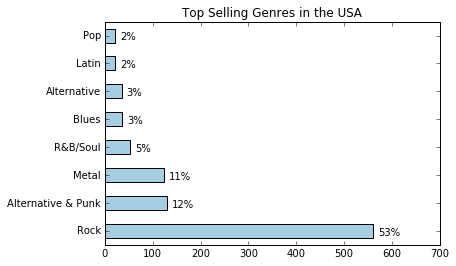

In [7]:
#For visualizations chose Blue: 
#About ~8% of caucasian men are color blind to red/green colors

genre_SUSA = run_query(to_purchase)
genre_SUSA.set_index("genre", inplace=True, drop=True)

genre_SUSA["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 700),
    colormap=plt.cm.Paired
)

plt.ylabel('')

for i, label in enumerate(list(genre_SUSA.index)):
    score = genre_SUSA.loc[label, "tracks_sold"]
    label = (genre_SUSA.loc[label, "percent_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

### Conclusion:
### The illustration above depicts Chinook's  top four selling genres in the USA. It is clear that the Rock genre overtakes the market as it makes up about 53% of the total sales. The genres of albumns available to add to Chinook's record store include Hip-Hop, Punk, Pop, and Blues. Based on Chinook's sales data, I would recommend selling the Punk, Blues, and Pop albumn. These albums are Red Tone, Slim Jim Bite, and Meteor and the Girls. However, I would urge the record label to keep an eye out for new Rock albumns with great potential. 



# Employee Sales Performance
## Analyze the purchases of customers belonging to each employee to see if any sales support agent is preforming either better or worse than the others.

In [8]:
agent_sales = '''
WITH sales AS
    (
    SELECT 
        i.customer_id,
        sum(i.total) total_sales,
        c.support_rep_id
    FROM invoice i
    INNER JOIN customer c on i.customer_id = c.customer_id
    GROUP BY c.support_rep_id
    )
SELECT 
    e.first_name || " " || e.last_name employee,
    e.reports_to,
    e.hire_date,
    e.city || ", " || e.state office,
    s.total_sales
FROM sales s 
INNER JOIN employee e on s.support_rep_id = e.employee_id 
GROUP BY e.employee_id
ORDER BY total_sales
'''

run_query(agent_sales)

,employee,reports_to,hire_date,office,total_sales
0,Steve Johnson,2,2017-10-17 00:00:00,"Calgary, AB",1393.92
1,Margaret Park,2,2017-05-03 00:00:00,"Calgary, AB",1584.00
2,Jane Peacock,2,2017-04-01 00:00:00,"Calgary, AB",1731.51


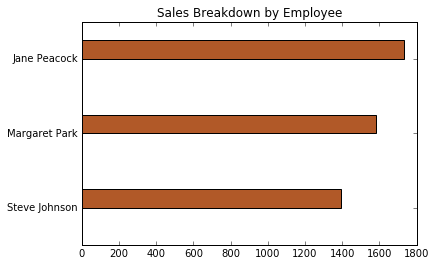

In [9]:
employee_sales = run_query(agent_sales)

employee_sales.set_index("employee", drop=True, inplace=True)

employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Paired
)
plt.ylabel('')
plt.show()

### Conclusion:
### The visualization above shows each employee's total sales. As depicted, Jane Peacock outpreforms her fellow employees by roughly 200 units. Steve Johnson seems to be underpreforming. Jane's sale behavior could be analyzed further and applied to help Steve advance in his sales career. However, it is worth noting that Jane was hired much before Steve and thus has more experience with the company.

# Analyzing Sales by Country

In [10]:
# Customer country, invoice total, group by country, sales of country / num customers
# order value/total num orders 
# Other: query that combines countries that only have one customer as "OTHER"
# Use 'CASE' which is similar to an if else statement to assign the other group

country_sales = '''
WITH other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    avg_customer_sale
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) avg_customer_sale,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(country_sales)



,country,customers,total_sales,average_order,avg_customer_sale
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


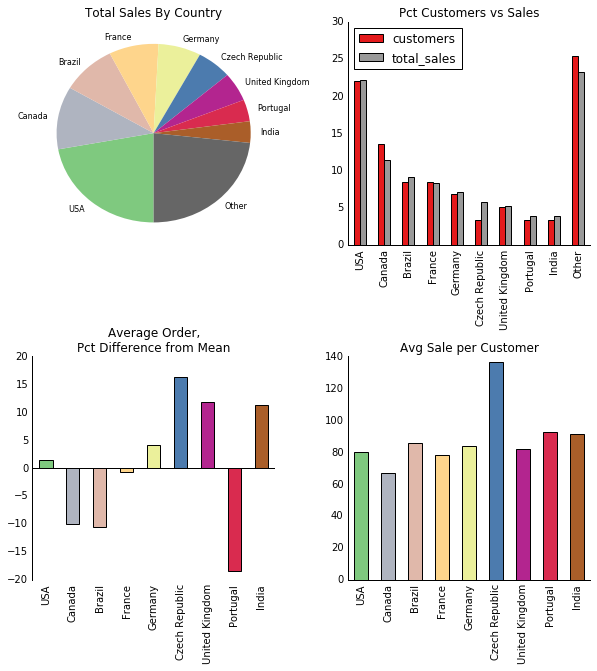

In [30]:
sales_data = run_query(country_sales)
sales_data.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sales_data.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#Pie chart
sales_breakdown = sales_data["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Total Sales By Country',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

#customer vs sales
col_nam = ["customers","total_sales"]
cust_sales = sales_data[col_nam].copy()
cust_sales.index.name = ''
for c in cust_sales:
    cust_sales[c] /= cust_sales[c].sum() / 100
cust_sales.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# deviation from mean
avg_order = sales_data["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# sales per customer
ltv = sales_data["avg_customer_sale"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Avg Sale per Customer"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)


plt.show()


### Conclusion:
### When examining different aspects of the data, there are certain criteria which highlight the potential of growth for certain countries. The first pie chart examines the sales per country. This visualization alone could be misleading, as it shows the USA selling the most. However, the two illustrations on the right show that USA customers do not make large purchases per customer. The bottom left visualizaiton shows that the United Kingdom and Czech Republic make 15-10% higher average orders than other countries. These countries, specifically, also demonstrate some of the largest average sales per customer. India, although not as strong, shows similar potential to Czech Republic and the United Kingdom. For these reasons, United Kingdom, Czech Republic and India show the most potential to increase Chinook's overall sales.